# Gradient Saliency Maps
Compute saliency-like maps from image gradients.

Code is taken from:

https://github.com/saketd403/Visualising-Image-Classification-Models-and-Saliency-Maps

In [92]:
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.compat.v1.keras.preprocessing import image
from tensorflow.compat.v1.keras.backend import set_session
import tensorflow.compat.v1.keras.backend as K
from tensorflow.compat.v1.keras.datasets import mnist
import numpy as np
import cv2

import matplotlib
import matplotlib.pyplot as plt

import os, sys, time
import random, importlib, argparse
from datetime import datetime

from utils.printi import printi
from utils.hyperparametermanager import HyperParameterManager
import utils.customdatagen as datagen

In [3]:
# Fix CuDNN issues with RTX cards
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config = config))

## Saliency maps with MNIST CNN

In [53]:
model = tf.keras.models.load_model('/home/pscl/Storage/Pretrained-Models/mnist_cnn.hdf5')

In [72]:
class Average_Saliency(object):
    def __init__(self, model, output_index=0):
        pass

    def get_grad(self, input_image):
        pass

    def get_average_grad(self, input_image, stdev_spread=.2, nsamples=50):
        stdev = stdev_spread * (np.max(input_image) - np.min(input_image))

        total_gradients = np.zeros_like(input_image, dtype = np.float64)
        for i in range(nsamples):
            noise = np.random.normal(0, stdev, input_image.shape)
            x_value_plus_noise = input_image + noise

            total_gradients += self.get_mask(x_value_plus_noise)

        return total_gradients / nsamples

class Single_Saliency(Average_Saliency):

    def __init__(self, model, output_index = 0):
        # Define the function to compute the gradient
        input_tensors = [model.input]
        gradients = model.optimizer.get_gradients(model.output[0][output_index], model.input)
        self.compute_gradients = K.function(inputs = input_tensors, outputs = gradients)

    def get_grad(self, input_image):
        # Execute the function to compute the gradient
        x_value = np.expand_dims(input_image, axis=0)
        gradients = self.compute_gradients([x_value])[0][0]

        return gradients

def get_derivative(model, image, label):
    print(f'Shape of input image:\t{image.shape}')
    print(f'Range of input image:\t{np.min(image)}, {np.max(image)}')
    gradients = tf.keras.backend.gradients(model.output[0][label], model.input)
    compute_gradients = tf.keras.backend.function(inputs=[model.input], outputs=gradients)
    #return compute_gradients([image])[0][0]
    return compute_gradients([np.expand_dims(image, axis=0)])[0][0]

In [55]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Reshape
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
# Normalize
x_train = x_train/255.0
x_test = x_test/255.0
# Categorical test data
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

Label: 5
Shape of input image:	(28, 28, 1)
Range of input image:	0.0, 1.0
Shape of gradients:	(28, 28, 1)


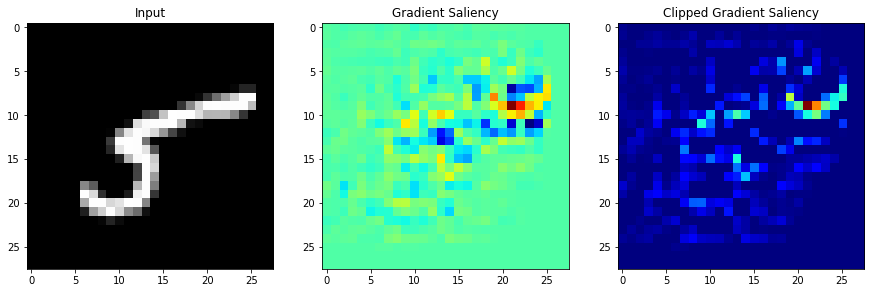

In [73]:
# Get some image and corresponding label
which = 65
img = x_train[which]
lbl = int(y_train[which])
print(f'Label: {lbl}')

grad = get_derivative(model, img, lbl)
print(f'Shape of gradients:\t{grad.shape}')
#single = Single_Saliency(mnist_model, lbl)
#grad = single.get_grad(img)
filter_grad = (grad > 0.0)[...,0]
#average_grad = single.get_average_grad(img)
#filter_average_grad = (average_grad > 0.0).reshape((28, 28))

plt.figure(figsize=(15,10))
plt.subplot(131, title='Input')
plt.imshow(img[:,:,0], cmap='gray')
plt.subplot(132, title='Gradient Saliency')
plt.imshow(grad[:,:,0], cmap = 'jet')
plt.subplot(133, title='Clipped Gradient Saliency')
plt.imshow(grad[:,:,0]*filter_grad, cmap = 'jet')
#plt.imshow(average_grad.reshape((28, 28)), cmap = 'jet')

#plt.imshow(average_grad.reshape((28, 28)) * filter_average_grad, cmap = 'gray')
plt.show()

## GradCAM with VGG16

In [114]:
model = VGG16(weights='imagenet', input_shape=(224,224,3))

In [127]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(224,224,3))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x

In [128]:
preprocessed_img = load_image('/home/pscl/Storage/Datasets/dog_example.jpg', preprocess=True)

In [129]:
predictions = model.predict(preprocessed_img)
top_n = 5
top = decode_predictions(predictions, top=top_n)[0]
classes = np.argsort(predictions[0])[-top_n:][::-1]
top_class = classes[0]
print('Model prediction:')
for c, p in zip(classes, top):
    print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))

Model prediction:
	basenji        	(253)	with probability 0.991
	Ibizan_hound   	(173)	with probability 0.007
	dingo          	(273)	with probability 0.001
	Pembroke       	(263)	with probability 0.000
	Cardigan       	(264)	with probability 0.000


In [148]:
def grad_cam(input_model, image, class_name, layer_name, img_W, img_H):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, class_name]
    conv_output = input_model.get_layer(layer_name).output
    grads = tf.keras.backend.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    grads = normalize(grads)
    gradient_function = tf.keras.backend.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (img_W, img_H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam, grads_val

In [136]:
gradcam, grads_val = grad_cam(model, preprocessed_img, 253, layer_name='block5_conv3', img_W=224, img_H=224)

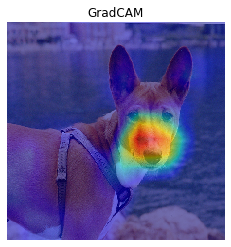

In [137]:
plt.title('GradCAM')
plt.axis('off')
plt.imshow(load_image('/home/pscl/Storage/Datasets/dog_example.jpg', preprocess=False))
plt.imshow(gradcam, cmap='jet', alpha=0.5)
plt.show()

## GradCAM with Saliency Model

In [142]:
model = tf.keras.models.load_model('/mnt/e/Pretrained-Models/affordance-maps/no_dropout_test.h5')

In [19]:
# Unfreeze all layers
for layer in model.layers:
    layer.trainable = True
# Recompile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = [tf.keras.metrics.Precision(), 
                         tf.keras.metrics.Recall()])

In [143]:
img = image.load_img('/home/pscl/Storage/Datasets/part-affordance-dataset-preprocessed/training/bowl_01_00000004_rgb.jpg', target_size=(130,130,3))
preprocessed_img = image.img_to_array(img)
preprocessed_img = np.expand_dims(preprocessed_img, axis=0)
preprocessed_img = preprocess_input(preprocessed_img)

In [144]:
from scipy.io import loadmat
y = loadmat('/home/pscl/Storage/Datasets/part-affordance-dataset-preprocessed/training/bowl_01_00000004_label.mat')['gt_label']
y = np.unique(y)
y = y[np.nonzero(y)]
label = int(y[0])

In [149]:
gradcam, grads_val = grad_cam(model, preprocessed_img, 6, layer_name='conv2d', img_W=130, img_H=130)

In [150]:
np.unique(grads_val)

array([1.], dtype=float32)

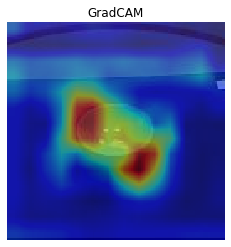

In [151]:
plt.title('GradCAM')
plt.axis('off')
plt.imshow(img)
plt.imshow(gradcam, cmap='jet', alpha=0.5)
plt.show()